# 1. Read Dataset=====================

### Create the data

https://cs231n.github.io/convolutional-networks/
https://medium.com/apache-mxnet/multi-channel-convolutions-explained-with-ms-excel-9bbf8eb77108

In [1]:
!pip install py7zr

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy
print('numpy:',numpy.version.version)

from platform import python_version
print('python:',python_version())

import torch
print('torch:', torch.__version__)

import matplotlib
from matplotlib import pyplot as plt
print('matplotlib:',matplotlib.__version__)

import seaborn as sns
print('seaborn:',sns.__version__)

import h5py
print('h5py:',h5py.__version__)


from platform import python_version
print('python version:', python_version())

import py7zr
print('py7zr:',py7zr.__version__)


numpy: 1.17.2
python: 3.6.7
torch: 1.10.0+cu102
matplotlib: 3.1.3
seaborn: 0.9.0
h5py: 2.10.0
python version: 3.6.7
py7zr: 0.19.2


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    print('No GPU available!')

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Allocated: 0.0 MB
Cached:    0.0 GB


In [4]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
from cycler import cycler
import matplotlib.style
import matplotlib as mpl
from mpl_toolkits import mplot3d 

from matplotlib.lines import Line2D
import seaborn as sns

nn.Module comes in handy while writing many DL model. For example when you are trying to code Maxout Network as defined in the paper [Maxout Networks] (https://arxiv.org/pdf/1302.4389.pdf 44).
https://github.com/pytorch/pytorch/commit/c7c8aaa7f040dd449dbc6aca9204b2f943aef477
https://discuss.pytorch.org/t/multiple-parallel-fully-connected-layers-type-torch-cuda-floattensor-but-found-type-torch-floattensor/37810
https://www.geeksforgeeks.org/single-neuron-neural-network-python/
https://rhettinger.wordpress.com/2011/05/26/super-considered-super/


In [5]:
%matplotlib notebook
import glob, os, os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import bisect
import scipy.sparse as sparse  #for baseline subtraction
from matplotlib import rc
# rc('mathtext', default='regular')
import h5py
# torch.set_printoptions(threshold=100000)
# plt.style.use('science')

In [6]:
import py7zr

In [7]:
import shutil  # unpacks in current path unless an additional path argument is provided
! curl --output Mg20Fe80O_ramp_xyfiles_1_349_azimuthal_integrated.7z \
https://zenodo.org/record/4424866/files/Mg20Fe80O_ramp_xyfiles_1_349_azimuthal_integrated.7z

import os

path="dataset_1"

if not os.path.isdir(path):
    print('The directory is not present. Creating a new one..')
    os.mkdir(path)
    print(path)
else:
    print('The directory is present.')
    print(path)
    
# %mkdir -p path

import py7zr
with py7zr.SevenZipFile("Mg20Fe80O_ramp_xyfiles_1_349_azimuthal_integrated.7z", 'r') as archive:
    archive.extractall(path)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6083k  100 6083k    0     0  2202k      0  0:00:02  0:00:02 --:--:-- 2202k
The directory is present.
dataset_1


In [8]:
hfont = {'fontname':'Helvetica'}

In [9]:
'''Definitions'''

def gaussian(x, x0, r, a, b):
    y = b + a*np.exp(-(x-x0)**2/(2*r**2))
    return y

def PseudoVoigtFunction(WavNr, Pos, Amp, GammaL, FracL):
    SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter  for the Gaussian distribution from GammaL (coupled in Pseudo-Voigt)
    LorentzPart = Amp / np.pi * (GammaL / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
    GaussPart = Amp / (np.sqrt(2*np.pi) * SigmaG) * np.exp( -(WavNr - Pos)**2 / (2 * SigmaG**2)) # Gaussian distribution
    Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts (or distributions)
    return Fit

#baseline subtraction based on Asymetric Least Square Smoothing
#https://zanran_storage.s3.amazonaws.com/www.science.uva.nl/ContentPages/443199618.pdf
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = sparse.linalg.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# Function which extracts the number of all XYfiles in the directory.    
run_no=0
def get_number_XYfiles(run_no):
    directory = os.listdir('dataset_1/')
    number_XYfiles = run_no
    for Dir in directory:
        number_XYfiles = number_XYfiles+1
    return(number_XYfiles)

In [10]:
# show the number of XYfiles found in the directory
total_XYfiles = get_number_XYfiles(run_no)
print(total_XYfiles)
total_XYfiles=350 #[Pt=1084, MgFeOB1_263]
print('The number of XYfiles within the chosen run is:', total_XYfiles)
%pwd
%mkdir -p ClassificationFigures
# save_figures_to = '../ClassificationFigures/'
save_figures_to = 'ClassificationFigures/'

349
The number of XYfiles within the chosen run is: 350


In [11]:
'''make sure that you have the right command directory selected'''
# %cd /gpfs/exfel/data/user/sunyue/Downloads/Brockhauser_Sandor/L2_Beamtime2019_Fe200culet_fe80mg20/XY/
%cd dataset_1
theta = [] 
I = []
baseline = []
Icorrect = []

test_y=total_XYfiles-2
for run_no in range(1,0+total_XYfiles):
    fileNO = str(run_no).zfill(4) 
    fname = 'l2_fe80mg20_ramp_00001_m1_'+str(run_no).zfill(4)+'.xy'
    thetas, Is = np.loadtxt(fname, skiprows=25, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is
    I.append(Is) # attaches a new array each time to a copy of previous, not really necessary here
    idx1 = 0
    idx2 = 4050
#background subtraction
#parameters lam and p have to be adjusted by hand!
#try 10**2 < lam < 10**9
#    0.001 <  p  < 0.1
    lam = 100000
    p = 0.002
    baselines = baseline_als(Is[idx1:idx2], lam, p)
    baseline.append(baselines)
    Icorrected = Is[idx1:idx2] - baselines
    Icorrect.append(Icorrected)
#    if (run_no==15): 
#        print(thetas.size, Is.shape,type(I),np.shape(I),len(Icorrected),len(baselines),sep='\n')
    thetas = thetas[idx1:idx2]
    theta.append(thetas)

/gpfs/exfel/data/user/sunyue/Mybinder_test2023/dataset_1


In [12]:
print(theta[0].shape,np.size(theta),len(theta),np.size(theta[0]))

(4023,) 1404027 349 4023


In [13]:
349*4023

1404027

<IPython.core.display.Javascript object>


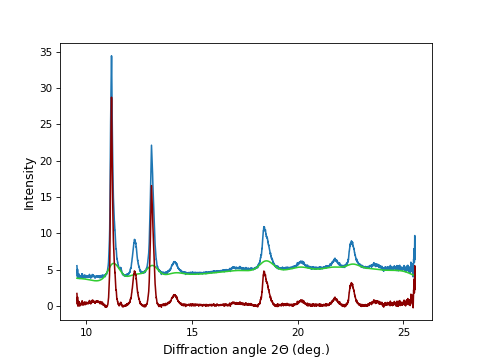

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [14]:
plt.figure()
plt.plot(theta[98], I[98][idx1:idx2])
plt.plot(theta[98], baseline[98],color = 'limegreen')
plt.plot(theta[98], Icorrect[98], color = 'darkred')
#plt.plot(theta[0], I[0], color = 'red')
#plt.plot(theta[1500], I[1500][idx1:idx2])
#plt.plot(theta[1500], baseline[1500])
#plt.plot(theta[450], Icorrect[450], color = 'limegreen')
#plt.plot(theta[420], I[420], color = 'limegreen')
plt.ylabel('Intensity', fontsize = 12)
plt.xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 12)
plt.tight_layout

In [15]:
def minibatch_plot_data(X, y, ai1=-1,ai2=1,bi1=-1,bi2=1,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
#     plt.axis('square')
#     plt.axis(np.array((ai1, ai2, bi1, bi2)) * zoom)
#     if auto is True: plt.axis('equal')
    plt.axis('on') 
    
def minibatch_plot_model(mndinx1,mndinx2,mndiny1,mndiny2,X2, y2, model):
    model.cpu()
#     nx, ny = (200, 200)
#     x = np.linspace(mndinx1, mndinx2, nx)
#     y = np.linspace(mndiny1,mndiny2, ny)
    x = np.arange(mndinx1, mndinx2, 0.02)
    y = np.arange(mndiny1, mndiny2, 0.001)
    xx, yy = np.meshgrid(x, y)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
    minibatch_plot_data(X2, y2,mndinx1,mndinx2,mndiny1,mndiny2,zoom=1)

In [16]:
def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', )#fontsize = 16,
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', )#fontsize = 16
#     plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.4, cmap=plt.cm.rainbow)

In [17]:
def set_default(figsize=(8,6)):
#     plt.style.use(['dark_background', 'bmh'])
#     plt.rc('figure', facecolor='none')
    plt.rc('figure', figsize=figsize)
    
def yue_plot_data(X, y, axl,axr,byl,byh,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity') # fontsize = 16,
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 16
    plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.6, cmap=plt.cm.rainbow)


def ys_plot_model(X, y, model):
    plt.figure(figsize=(8,6))
    bx = plt.subplot(111)
#     bx.set_ylabel('Intensity', )#fontsize = 16,
#     bx.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', )#fontsize = 16
    plt.axis([axl, axr, byl, byh])
    
    
    model.cpu()
    X=X.cpu()
    mesh1 = np.arange(axl, axr, 0.01)
    mesh2 = np.arange(byl, byh, 0.01)
    xx, yy = np.meshgrid(mesh1, mesh2)
    
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float().cpu()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)     
    yue_plot_data(X, y, axl,axr,byl,byh)
    
def yue_plot_3D(X, X_axis):
    X = X.cpu()
    X_axis = X_axis.cpu()    
    
    fig = plt.figure(figsize = (10, 7)) 
    ax = plt.axes(projection ="3d") 

    # Creating plot 
    ax.scatter3D(X_axis.numpy(), X.numpy()[:, 0], X.numpy()[:, 1],s=0.3, color = "green"); 
    
    plt.title("Spectra 3D scatter plot") 
    ax.set_xlabel('X-axis', fontweight ='bold')  
    ax.set_ylabel('angle', fontweight ='bold')  
    ax.set_zlabel('intensity', fontweight ='bold') 

    # show plot 
    plt.show() 

In [18]:
set_default()

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Select Representative spectra for Training & Testing ===========

###  data for training

In [20]:
%cd -

/gpfs/exfel/data/user/sunyue/Mybinder_test2023


<IPython.core.display.Javascript object>


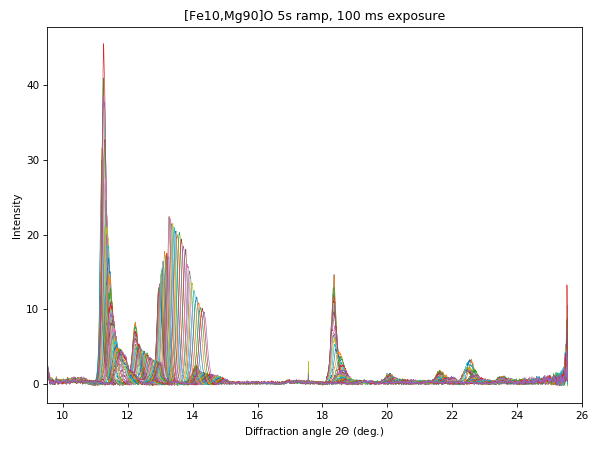

(4023,) 35 19


In [21]:

# data for training
#plotting various plots to show development of bcc -> hcp transition
plt.figure()#figsize=(8,8)

plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

ax = plt.subplot(111)
N=len(theta[0])

X_1 = []# training: theta
X_2 = []# training: intensity
y   = []
global Ci,Ci_0,div_num,gap #indicates num of curves, and curves of class0.
div_num = 185 #indicates the boundary of spectral curves.
gap = 10
Ci = 0  
Ci_0 = 0
X_axis=[] # used to store data for 3D plotting

for pct in range(0,total_XYfiles-1,gap):
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = 'limegreen' if pct <200 else 'blue')
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = color_sequence[Ci])
#     ax.plot(theta[pct], Icorrect[pct]+6-pct/50.,lw=1)
    ax.plot(theta[pct], Icorrect[pct],lw=0.6)
 
    #testX = torch.FloatTensor(theta[pct])
    #testX = torch.cat((testX),1)
    
    Icorrect_t = Icorrect[pct]
#     Icorrect_t = Icorrect[pct]+6-pct/50.
    theta_t = theta[pct]
    X_1.append(theta_t)
    X_2.append(Icorrect_t)
    X_axis.append(np.ones(N)*pct) 
    
    Ci += 1
    if pct <div_num:
        Ci_0 += 1
    #y.append(torch.zeros(1,size(theta[pct])) if pct < 200 else torch.ones(1,size(theta[pct]))

             
print(X_1[0].shape,Ci,Ci_0)


ax.set_ylabel('Intensity')
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')
# ax.set_ylim(-2,45)
ax.set_xlim(9.5,26)

plt.title('[Fe10,Mg90]O 5s ramp, 100 ms exposure') #, fontweight='bold'

# ax.spines['right'].set_visible(False) #remove right axis spine
# ax.spines['top'].set_visible(False) # remove top axis spine
plt.tight_layout()
plt.savefig(save_figures_to+"Original data used for training.png", bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


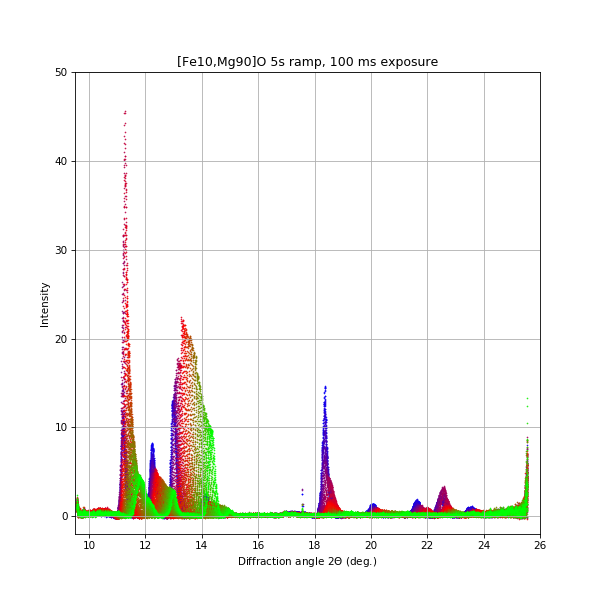

In [22]:
#plotting spectra in another way
plt.figure(figsize=(8,8))
plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16

ax = plt.subplot(111)
t_gap = gap # this parameter decide the number of spectral curves for test.

import matplotlib.cm as cm
colors = cm.brg(np.linspace(0, 1, len(range(0,total_XYfiles-1,t_gap)))) # or gist_rainbow

pos_d=0
for pct,cc in zip(range(0,total_XYfiles-1,t_gap),colors):
    pct = pct+pos_d
    plt.scatter(theta[pct], Icorrect[pct], color=cc,s=0.3)
    
ax.set_ylabel('Intensity') #, fontsize = 16,
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 16
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)
plt.grid(True)
plt.title('[Fe10,Mg90]O 5s ramp, 100 ms exposure') #, fontsize=16, fontweight='bold'
plt.savefig(save_figures_to+"Spectra data for testing (manually classified).png", bbox_inches='tight', dpi=600)

plt.tight_layout()


torch.Size([35, 4023])
torch.Size([140805, 1])


<IPython.core.display.Javascript object>


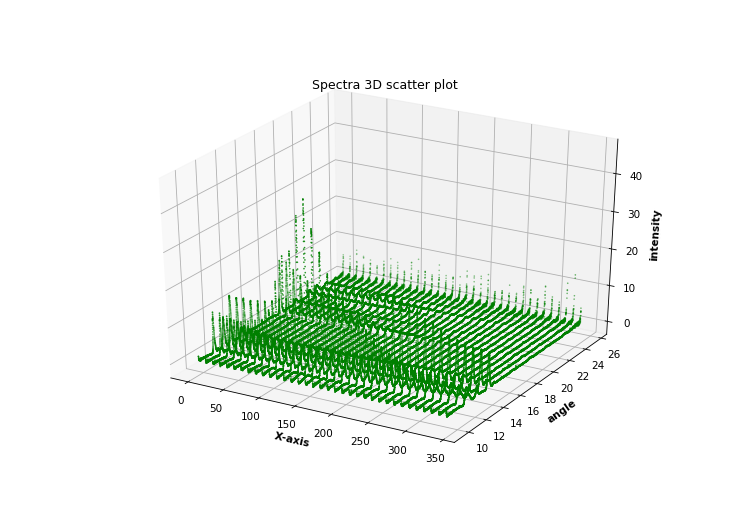

<IPython.core.display.Javascript object>


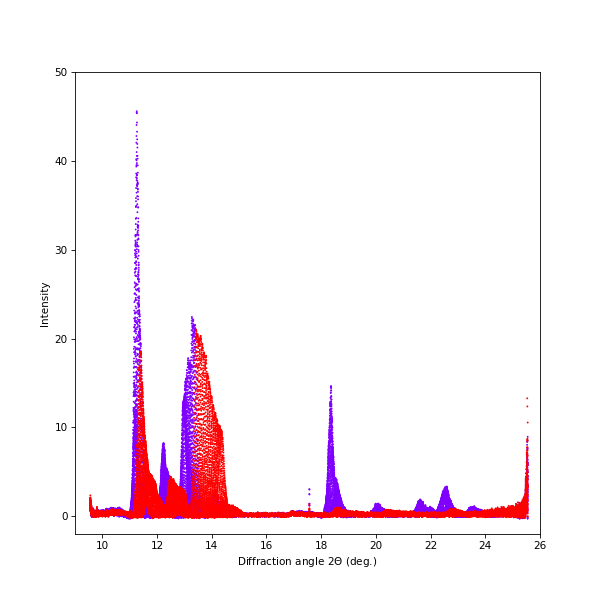

In [23]:
# data for training

global axl,axr,byl,byh,Ci
X_1=torch.FloatTensor(X_1)
X_2=torch.FloatTensor(X_2)
print(X_1.shape)
X_1=torch.reshape(X_1,(-1,1))
X_2=torch.reshape(X_2,(-1,1))
print(X_2.shape)
X_TR=torch.cat((X_1,X_2),1).to(device)

y_1 = torch.zeros(Ci_0 * (theta[0].size), dtype=torch.long)
y_2 = torch.ones((Ci-Ci_0)* (theta[0].size), dtype=torch.long)
Y_TR   = torch.cat((y_1,y_2),0).to(device)
# print(X_1.shape,X_2.shape,X.shape,y.shape,y,X_1,X_2,sep='\n')

# plot 3D spectra data
X_axis=torch.FloatTensor(X_axis)
X_axis=torch.reshape(X_axis,(-1,1))
yue_plot_3D(X_TR,X_axis)


axl=9
axr=26
byl=-2
byh=50

plt.figure(figsize=(8,8))
yue_plot_data(X_TR, Y_TR, axl,axr,byl,byh)
plt.savefig(save_figures_to+"Original data used for training(manually classified).png", bbox_inches='tight', dpi=600)


# X = X.cpu()
# y = y.cpu()
# plt.figure()
# plt.scatter(X.numpy()[:, 1], X.numpy()[:, 0], s=0.2)
# plt.show()


In [24]:
X_2.shape

torch.Size([140805, 1])

In [25]:
# p_num_c0=[i for i in range(8)] #[0,2,4,5,7,8,10,15] #1 #5  class 0 class 1 class 0
# p_num_c1=[i for i in np.arange(11,17)] #[22,24,28,30,32,34] #1 #5  class 0 class 1 class 0
# # p_num_c0= [2,4,7] #[i for i in range(16)] #[0,2,4,5,7,8,10,15] #1 #5  class 0 class 1 class 0
# # p_num_c1= [13,15,17] #[i for i in np.arange(22,34)] #[22,24,28,30,32,34] #1 #5  class 0 class 1 class 0
# p_num = p_num_c0 + p_num_c1
# print(p_num)
# N_TrainOrg = len(p_num)
# Train_Gap = gap
# X_2 = torch.reshape(X_2, (-1, N))
# print(X_2.shape)
# Xtemp = torch.zeros(len(p_num),N)
# Xtemp_s = torch.zeros(len(p_num),N)
# X_Extrem_tmp = torch.empty(0,N)
# for i in range(len(p_num)):
#     Xtemp[i] = X_2[p_num[i]] # intensity
#     print(X_Extrem_tmp.shape,Xtemp[i].shape)
#     X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp[i],(1,-1))),0)
# print(Xtemp.shape)

# X_Extrem= torch.empty(0,N)
# X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.

# plt.figure(figsize=(8,6))
# ax = plt.subplot(111)
# for n in range(len(p_num)):
#     ax.plot(Xtemp[n],lw=0.6,color='red'if (p_num[n]*Train_Gap < 160) else 'blue')
# N_sim = 100 # number of simulated spectra for each original ones

# plt.figure(figsize=(8,6))
# ax = plt.subplot(111)
# for n in range(N_sim):
#     X_Extrem_tmp = torch.empty(0,N)
#     seed = n*1000
#     random.seed(seed)
#     torch.manual_seed(seed)
#     for j in range(len(p_num)):
#         for i in range(N):
#             Xtemp_s[j,i] = Xtemp[j,i] +random.random()/12
#         ax.plot(Xtemp_s[j],lw=0.6,color='red' if j< len(p_num_c0) else 'blue')
#         X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp_s[j],(1,-1))),0)
#     X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.
# #     y_Extrem_tmp=torch.cat((ytemp1,ytemp2),0)
# #     y_Extrem    =torch.cat((y_Extrem,y_Extrem_tmp),0)
# # one row for one spectral curve:
# print((X_Extrem).shape)

# plt.tight_layout()


# N_Train=N_TrainOrg*N_sim+N_TrainOrg


# #  ===============================method 2============================
# global X2,y2  
# X2 = X_Extrem.to(device)
# y2_orig = torch.cat((torch.zeros(len(p_num_c0),1),torch.ones(len(p_num_c1),1)),0)
# y2 = torch.empty(0)
# for n in range((N_sim+1)):
#     y2= torch.cat([y2, y2_orig], dim=0) 

# y2 = torch.reshape(y2,(-1,1)).to(device)
# print(X2.shape,y2.shape,type(y2))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
torch.Size([35, 4023])
torch.Size([31, 4023])


<IPython.core.display.Javascript object>


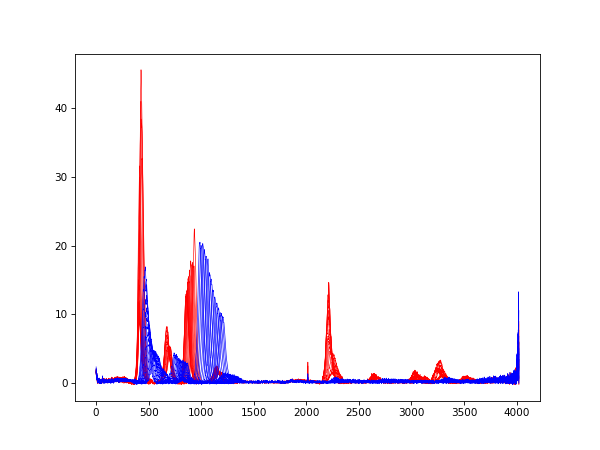

torch.Size([1581, 4023])
torch.Size([1581, 4023]) torch.Size([1581, 1]) <class 'torch.Tensor'>


In [26]:
p_num_c0=[i for i in range(16)] #[0,2,4,5,7,8,10,15] #1 #5  class 0 class 1 class 0
p_num_c1=[i for i in np.arange(20,35)] #[22,24,28,30,32,34] #1 #5  class 0 class 1 class 0

# p_num_c0=[i for i in range(8)] #[0,2,4,5,7,8,10,15] #1 #5  class 0 class 1 class 0
# p_num_c1=[i for i in np.arange(11,17)] #[22,24,28,30,32,34] #1 #5  class 0 class 1 class 0
p_num = p_num_c0 + p_num_c1
print(p_num)
N_TrainOrg = len(p_num)
Train_Gap = gap
X_2 = torch.reshape(X_2, (-1, N))
print(X_2.shape)
Xtemp = torch.zeros(len(p_num),N)
Xtemp_s = torch.zeros(len(p_num),N)
X_Extrem_tmp = torch.empty(0,N)
for i in range(len(p_num)):
    Xtemp[i] = X_2[p_num[i]] # intensity
#     print(X_Extrem_tmp.shape,Xtemp[i].shape)
    X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp[i],(1,-1))),0)
print(Xtemp.shape)

X_Extrem= torch.empty(0,N)
X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.

plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for n in range(len(p_num)):
    ax.plot(Xtemp[n],lw=0.6,color='red'if (p_num[n]*Train_Gap < 160) else 'blue')
N_sim = 50 # number of simulated spectra for each original ones

# plt.figure(figsize=(8,6))
# ax = plt.subplot(111)
for n in range(N_sim):
    X_Extrem_tmp = torch.empty(0,N)
    seed = n*1000
    random.seed(seed)
    torch.manual_seed(seed)
    for j in range(len(p_num)):
        for i in range(N):
            Xtemp_s[j,i] = Xtemp[j,i] +random.random()/6
#         ax.plot(Xtemp_s[j],lw=0.6,color='red' if j< len(p_num_c0) else 'blue')
        X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp_s[j],(1,-1))),0)
    X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.
#     y_Extrem_tmp=torch.cat((ytemp1,ytemp2),0)
#     y_Extrem    =torch.cat((y_Extrem,y_Extrem_tmp),0)
# one row for one spectral curve:
print((X_Extrem).shape)

# plt.tight_layout()


N_Train=N_TrainOrg*N_sim+N_TrainOrg


#  ===============================method 2============================
global X2,y2  
X2 = X_Extrem.to(device)
y2_orig = torch.cat((torch.zeros(len(p_num_c0),1),torch.ones(len(p_num_c1),1)),0)
y2 = torch.empty(0)
for n in range((N_sim+1)):
    y2= torch.cat([y2, y2_orig], dim=0) 

y2 = torch.reshape(y2,(-1,1)).to(device)
print(X2.shape,y2.shape,type(y2))

### data for testing

<IPython.core.display.Javascript object>


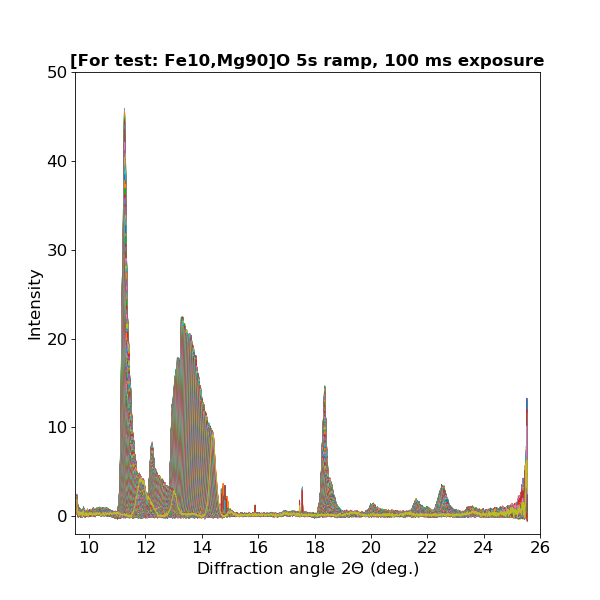

0 [] 349 <class 'list'> <class 'list'>
349 185


In [27]:
## plotting various plots to show development of bcc -> hcp transition
plt.figure(figsize=(8,8))

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

ax = plt.subplot(111)

Xt_1 = []# theta for test
Xt_2 = []# intensity for test
yt   = []
global Ntn,Ntn_0 #indicates num of test curves, and curves of class0.
Ntn = 0  # num of test curves,
Ntn_0 = 0 #and num of curves of class0
pos_d=0
t_gap=1
for pct in range(0,total_XYfiles-1,t_gap):
    pct = pct+pos_d
    ax.plot(theta[pct], Icorrect[pct], color = 'limegreen' if pct <200 else 'red',lw=0.8)
#     ax.plot(theta[pct], Icorrect[pct],lw=0.8)
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = color_sequence[Ci])
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50.)
    Ntn += 1
    if pct <div_num:
        Ntn_0 += 1
#         yt.append(np.zeros(theta[0].size)) # tensor type
#     else:
#         yt.append(np.ones(theta[0].size))
    

    Icorrect_t = Icorrect[pct]
    theta_t = theta[pct]
    Xt_1.append(theta_t)
    Xt_2.append(Icorrect_t)
    #y.append(torch.zeros(1,size(theta[pct])) if pct < 200 else torch.ones(1,size(theta[pct]))

print(len(yt),yt,len(Xt_1),type(Xt_1),type(yt))            


ax.set_ylabel('Intensity', fontsize = 16,)
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 16)
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)

plt.title('[For test: Fe10,Mg90]O 5s ramp, 100 ms exposure', fontsize=16, fontweight='bold')
plt.savefig(save_figures_to+"Spectra data for testing (manually classified).png", bbox_inches='tight', dpi=600)

# ax.spines['right'].set_visible(False) #remove right axis spine
# ax.spines['top'].set_visible(False) # remove top axis spine
plt.tight_layout()
print(Ntn,Ntn_0)

In [28]:
# plot spectra data for testing (not classified)
ax = plt.subplot(111)
for i in range(0,total_XYfiles-1,1):
    i = i+pos_d
    ax.plot(theta[i], Icorrect[i],lw=0.8)
ax.set_ylabel('Intensity', fontsize = 16,)
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 16)
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)

plt.title('[For test: Fe10,Mg90]O 5s ramp, 100 ms exposure', fontsize=16, fontweight='bold')
plt.savefig(save_figures_to+"Spectra data for testing.png", bbox_inches='tight', dpi=600)

plt.tight_layout()
print(Ntn,Ntn_0)

349 185


In [29]:
print(type(theta_t))

<class 'numpy.ndarray'>


### testing input & examples

<class 'list'>


<IPython.core.display.Javascript object>


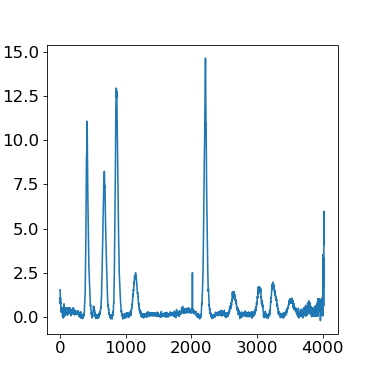

torch.Size([349, 4023]) <class 'torch.Tensor'> <class 'list'>


In [30]:
# data for testing
global Xt,yt
print(type(Xt_1))
Xt_1=torch.FloatTensor(Xt_1) # convert list type to tensor
Xt_2=torch.FloatTensor(Xt_2) # convert list type to tensor
Xt_1=torch.reshape(Xt_1,(-1,N))
Xt_2=torch.reshape(Xt_2,(-1,N))

Xt_1plt=torch.reshape(Xt_1,(-1,1))
Xt_2plt=torch.reshape(Xt_2,(-1,1))
Xt=torch.cat((Xt_1plt,Xt_2plt),1).to(device)

X2t=Xt_2.to(device) # only use intensity information
plt.figure(figsize=(5,5))
plt.plot(Xt_2[0,:])

# yt_1 = torch.zeros(Ntn_0 * (theta[0].size), dtype=torch.long)
# yt_2 = torch.ones((Ntn-Ntn_0)* (theta[0].size), dtype=torch.long)
# yt   = torch.cat((yt_1,yt_2),0).to(device)
# print(Xt_1.shape,Xt_2.shape,Ntn,Ntn_0,Xt.shape,yt.shape,yt,Xt_1,Xt_2,sep='\n')
print(X2t.shape,type(Xt_1),type(yt))



# yue_plot_data(Xt, yt, axl,axr,byl,byh)

# 3. Bulid Model and Training process==========

In [31]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [32]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = np.size(theta[0])  # num_samples_per_class
D = 2  # dimensions
C = 2  # num_classes
H = 50 # num_hidden_units
B = 33 # num_bins
S = 0 #bin id
# Ntn= 2 # num_test_classes
Si=0
iternum = 5 #4
n_feature =20

global N2 
global N_Train

N2=int(N/B)

model_path = os.getcwd() +'/ModelPath/'

if not os.path.isdir(model_path):
    print('The directory is not present. Creating a new one..')
    os.mkdir(model_path)
    print(model_path)
else:
    print('The directory is present.')

# %mkdir -p "model_path"

The directory is present.


In [33]:
os.getcwd()

'/gpfs/exfel/data/user/sunyue/Mybinder_test2023'

In [34]:
print(model_path)

/gpfs/exfel/data/user/sunyue/Mybinder_test2023/ModelPath/


In [35]:
# model =  nn.Transformer(nhead=8, num_encoder_layers=6)
# model.to(device)
# x = torch.randn(BATCH_SIZE, IN_DIM)

nn.Conv1d() applies 1D convolution over the input. nn.Conv1d() expects the input to be of the shape [batch_size, input_channels, signal_length] .
Conv1d — Input 2d
To apply 1D convolution on a 2d input signal, we can do the following. First, we define our input tensor of the size [1, 2, 5] where batch_size = 1, input_channels = 2 , and signal_length = 5 .


You are forgetting the "minibatch dimension", each "1D" sample has indeed two dimensions: the number of channels (7 in your example) and length (10 in your case). However, pytorch expects as input not a single sample, but rather a minibatch of B samples stacked together along the "minibatch dimension".
So a "1D" CNN in pytorch expects a 3D tensor as input: BxCxT. If you only have one signal, you can add a singleton dimension:

 out = model(torch.tensor(X)[None, ...])

If we set all the maxpool with parameters 2, we get interesting parameters

**1. Build your model**

In [36]:
class CNN(nn.Module):
    def __init__(self, O_channel0 = 64,  O_channel1 = 64, O_channel2= 4 , O_feature=1,output_dim = 1, hidden_size = 150, BinNum = B):
        super(CNN,self).__init__()
        self.BinNum = BinNum
        self.LayerNorm = nn.LayerNorm(N)
        self.conv1 = nn.Sequential(nn.Conv1d(1, O_channel0, kernel_size=5,stride=2),
                                   nn.BatchNorm1d(O_channel0),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2)
                                   )
        self.conv2 = nn.Sequential(nn.Conv1d(O_channel0, O_channel1, kernel_size=3,stride=2),
                                   nn.BatchNorm1d(O_channel1),
                                   nn.ReLU(),
                                   nn.MaxPool1d(3)  #3
                                   )
        self.conv3 = nn.Sequential(nn.Conv1d(O_channel1, O_channel2, kernel_size=3),
                                   nn.BatchNorm1d(O_channel2),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2)
                                   )
        input_shape = (1, 1, N) # just for test, in order to get the shape of FNN input neurons            
        self.output_dimension = self._get_conv_output(input_shape)

        self.fc1 = nn.Sequential(
            nn.LayerNorm(self.output_dimension),
            nn.Linear(self.output_dimension, O_feature),          
            nn.Sigmoid()
        )
        self._create_weights()

    def _create_weights(self, mean=0.0, std=0.05):
        for module in self.modules():
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                module.weight.data.normal_(mean, std) 
                
    def _get_conv_output(self, shape):
        x = torch.rand(shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output_dimension = x.size(1)
        return output_dimension
    
    def forward(self, x):
        In_Conv = x
        In_Conv = torch.reshape(In_Conv,(-1,1,N))
        In_Conv  = self.LayerNorm(In_Conv)
        In_Conv  = self.conv1(In_Conv)  
        In_Conv  = self.conv2(In_Conv)
        In_Conv  = self.conv3(In_Conv)
        In_Conv  = In_Conv.view(In_Conv.size(0), -1)
        In_Conv  = self.fc1(In_Conv)
        return In_Conv

    def save(self, path=model_path+"CNN.pth", **kwargs):
        print("\nsaving model to "+path)
        model_state = self.state_dict()
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(dict(model_state=model_state,**kwargs),path)

    def load(self, path):
        print("loading model from "+path)
        snapshot = torch.load(path, map_location="cpu")
        model_state = snapshot.pop('model_state', snapshot)
        self.load_state_dict(model_state)
        return snapshot

In [37]:

class CNN(nn.Module):
    def __init__(self, O_channel0 = 64,  O_channel1 = 64, O_channel2= 4 , O_feature=1,output_dim = 1, hidden_size = 150, BinNum = B):
        super(CNN,self).__init__()
        self.BinNum = BinNum
        self.LayerNorm = nn.LayerNorm(N)
        self.conv1 = nn.Sequential(nn.Conv1d(1, O_channel0, kernel_size=5,stride=2),
                                   nn.BatchNorm1d(O_channel0),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2)
                                   )
        self.conv2 = nn.Sequential(nn.Conv1d(O_channel0, O_channel1, kernel_size=3,stride=2),
                                   nn.BatchNorm1d(O_channel1),
                                   nn.ReLU(),
                                   nn.MaxPool1d(3)  #3
                                   )
        self.conv3 = nn.Sequential(nn.Conv1d(O_channel1, O_channel2, kernel_size=3),
                                   nn.BatchNorm1d(O_channel2),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2)
                                   )
        input_shape = (1, 1, N) # just for test, in order to get the shape of FNN input neurons            
        self.output_dimension = self._get_conv_output(input_shape)

        self.fc1 = nn.Sequential(
            nn.LayerNorm(self.output_dimension),
            nn.Linear(self.output_dimension, O_feature),          
            nn.Sigmoid()
        )
#         self.fc1 = nn.Sequential(
#             nn.Linear(self.output_dimension, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, O_feature),            
#             nn.Sigmoid()
# #             nn.Dropout(0.5)
#         )

        self._create_weights()
        
    def _create_weights(self, mean=0.0, std=0.05):
        for module in self.modules():
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                module.weight.data.normal_(mean, std) 
                
    def _get_conv_output(self, shape):
        x = torch.rand(shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output_dimension = x.size(1)
        return output_dimension
    
    def forward(self, x):
        In_Conv = x
        In_Conv = torch.reshape(In_Conv,(-1,1,N))
        In_Conv  = self.LayerNorm(In_Conv)
        In_Conv  = self.conv1(In_Conv)  
        In_Conv  = self.conv2(In_Conv)
        In_Conv  = self.conv3(In_Conv)
        In_Conv  = In_Conv.view(In_Conv.size(0), -1)
        In_Conv  = self.fc1(In_Conv)
        return In_Conv
 
    def save(self, path=model_path+"CNN.pth", **kwargs):
        print("\nsaving model to "+path)
        model_state = self.state_dict()
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(dict(model_state=model_state,**kwargs),path)

    def load(self, path):
        print("loading model from "+path)
        snapshot = torch.load(path, map_location="cpu")
        model_state = snapshot.pop('model_state', snapshot)
        self.load_state_dict(model_state)
        return snapshot


In [38]:
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

  

# class MultiBinSegm(nn.Module):
#     def __init__(self, n_feature=128,  O_channel=16, O_feature=1,output_dim = 1, hidden_size = 150, BinNum = B):
#         super(MultiBinSegm,self).__init__()
#         self.BinNum = BinNum
#         self.LayerNorm = nn.LayerNorm(N)
#         self.conv1 = nn.Sequential(nn.Conv1d(1, n_feature, kernel_size=5,stride=2),
#                                    nn.BatchNorm1d(n_feature),
#                                    nn.ReLU(),
#                                    nn.MaxPool1d(2)
#                                    )
#         self.conv2 = nn.Sequential(nn.Conv1d(n_feature, n_feature, kernel_size=3,stride=2),
#                                    nn.BatchNorm1d(n_feature),
#                                    nn.ReLU(),
#                                    nn.MaxPool1d(2)
#                                    )
#         self.conv3 = nn.Sequential(nn.Conv1d(n_feature, O_channel, kernel_size=5),
#                                    nn.BatchNorm1d(O_channel),
#                                    nn.ReLU(),
#                                    nn.MaxPool1d(4)
#                                    )
#         input_shape = (1, 1, N) # just for test, in order to get the shape of FNN input neurons            
#         self.output_dimension = self._get_conv_output(input_shape)

#         self.fc1 = nn.Sequential(
#             nn.Linear(self.output_dimension, O_feature),          
#             nn.Sigmoid()
#         )
            
# #         self.fc1 = nn.Sequential(
# #             nn.Linear(self.output_dimension, hidden_size),
# #             nn.ReLU(),
# #             nn.Linear(hidden_size, O_feature),            
# #             nn.Sigmoid()
# # #             nn.Dropout(0.5)
# #         )
            
#         self._create_weights()
        


#     def _create_weights(self, mean=0.0, std=0.05):
#         for module in self.modules():
#             if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
#                 module.weight.data.normal_(mean, std) 
                
#     def _get_conv_output(self, shape):
#         x = torch.rand(shape)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = x.view(x.size(0), -1)
#         output_dimension = x.size(1)
#         return output_dimension
    
#     def forward(self, x):
#         In_Conv = x
#         In_Conv = torch.reshape(In_Conv,(-1,1,N))
# #         In_Conv  = self.LayerNorm(In_Conv)
#         In_Conv  = self.conv1(In_Conv)  
#         In_Conv  = self.conv2(In_Conv)
#         In_Conv  = self.conv3(In_Conv)
#         In_Conv  = In_Conv.view(In_Conv.size(0), -1)
#         In_Conv  = self.fc1(In_Conv)
#         return In_Conv

 

#     def save(self, path=model_path+"CNN.pth", **kwargs):
#         print("\nsaving model to "+path)
#         model_state = self.state_dict()
#         os.makedirs(os.path.dirname(path), exist_ok=True)
#         torch.save(dict(model_state=model_state,**kwargs),path)

#     def load(self, path):
#         print("loading model from "+path)
#         snapshot = torch.load(path, map_location="cpu")
#         model_state = snapshot.pop('model_state', snapshot)
#         self.load_state_dict(model_state)
#         return snapshot


In [39]:
Trained_Model = model_path+"CNN_2mpool3.pth"
Trained_Model

'/gpfs/exfel/data/user/sunyue/Mybinder_test2023/ModelPath/CNN_2mpool3.pth'

In [40]:

OUT_Dim =1  
O_FeatCOV=1
model = CNN(
    output_dim = OUT_Dim,
    hidden_size = H,
    O_feature=O_FeatCOV,
    BinNum = B
)
model.to(device)
# x = torch.randn(BATCH_SIZE, IN_DIM)

# src = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
# out = transformer_model(src)

CNN(
  (LayerNorm): LayerNorm((4023,), eps=1e-05, elementwise_affine=True)
  (conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 4, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): LayerNorm((328,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=328

In [41]:
for name,param in model.named_parameters():
    print(name,type(param), param.size())
    
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params:',pytorch_total_params)

LayerNorm.weight <class 'torch.nn.parameter.Parameter'> torch.Size([4023])
LayerNorm.bias <class 'torch.nn.parameter.Parameter'> torch.Size([4023])
conv1.0.weight <class 'torch.nn.parameter.Parameter'> torch.Size([64, 1, 5])
conv1.0.bias <class 'torch.nn.parameter.Parameter'> torch.Size([64])
conv1.1.weight <class 'torch.nn.parameter.Parameter'> torch.Size([64])
conv1.1.bias <class 'torch.nn.parameter.Parameter'> torch.Size([64])
conv2.0.weight <class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3])
conv2.0.bias <class 'torch.nn.parameter.Parameter'> torch.Size([64])
conv2.1.weight <class 'torch.nn.parameter.Parameter'> torch.Size([64])
conv2.1.bias <class 'torch.nn.parameter.Parameter'> torch.Size([64])
conv3.0.weight <class 'torch.nn.parameter.Parameter'> torch.Size([4, 64, 3])
conv3.0.bias <class 'torch.nn.parameter.Parameter'> torch.Size([4])
conv3.1.weight <class 'torch.nn.parameter.Parameter'> torch.Size([4])
conv3.1.bias <class 'torch.nn.parameter.Parameter'> torch.Size([

### Representative curves for training

In [42]:
print(y2.t(),y2.shape,len(y2))

tensor([[0., 0., 0.,  ..., 1., 1., 1.]], device='cuda:0') torch.Size([1581, 1]) 1581


In [43]:
print(X2.shape)
# print(X2)
# YY=torch.rand(8,4023)
# print(model(X2))
# print( model(YY))
# X2 = torch.reshape(X2,(-1,1,self.input_size))

torch.Size([1581, 4023])


## Training process

In [44]:
# train NN in each bin
def TrainingProc():
    global X2,y2
#     X2 = torch.zeros(N2 * N_Train, D*B).to(device)
#     y2 = torch.zeros(N2 * N_Train, 1, dtype=torch.float).to(device)    
    
#     for b in range(B):
#         for ix in range(N2):
#             for ic in range(N_Train):
#                 X2[ix+ic*N2,2*b:2*b+2] = X_Extrem[b*N2+ix+ic*N]
#                 y2[ix+ic*N2] = y_Extrem[b*N2+ix+ic*N]
    #print("X2:", tuple(X2.size()))
    #print("y2:", tuple(y2.size()))
    #print('y2.shape',y2.shape)
    
    learning_rate = 2e-3  # 8e-3
    lambda_l2 = 2e-5
    # nn package to create our linear model
    # each Linear module has a weight and bias

#     model = nn.Sequential(
#         nn.Linear(D*B, H),
#         nn.ReLU(),

# #         nn.Linear(H, int(H/C)),
# #         nn.ReLU(),
# #         nn.Linear(H, C),
# #         nn.ReLU(),
#         nn.Linear(H, 1),
#         nn.Sigmoid()
#     )
#     model.to(device)

    # nn package also has different loss functions.
    # we use cross entropy loss for our classification task
    criterion = torch.nn.BCELoss()

    # we use the optim package to apply
    # ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
    #optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, betas=(0.8, 0.999), eps=1e-08, weight_decay=0) # built-in L2

    # e = 1.  # plotting purpose

    # Training
    dh=display.display("Training",display_id=True)
    for t in range(iternum):
        # Feed forward to get the logits
#         X2 = nn.LayerNorm(X2.shape[1])
        y_pred = model(X2)
#         print(y_pred)
        y_pred = y_pred.squeeze(0)
#         y_pred = model(X_Extrem_x,X_Extrem_y)
#         print('y_pred：',y_pred.shape)
        # Compute the loss and accuracy
        loss = criterion(y_pred, y2)
        predicted = y_pred > 0.5
#         print(y2,predicted)
        acc = (y2 == predicted).sum().float() / len(y2)
        dh.update(" [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % ( t, loss.item(), acc))
        #display.clear_output(wait=True)
              
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
    
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()
    
        # Update params
        optimizer.step()
        
    #print(len(y2),y_pred.size(),loss,sep='\n') 
    return acc
#     return acc,model

In [45]:
# ====================Training Flag=======================
####If you want to train the model by your self:
Training_flag = 0
####Else Training_flag = 0

In [46]:
# pick two extreme curves for training and generate test data in each bin
global Acc,N2
N2=int(N/B)
ytest_pred=[]


if Training_flag ==1: 
    # ====================training=======================
    ####If you want to train the model yourself
    ######################################
    from time import time
    t0= time()
    Acc =TrainingProc()   
    t1= time()
    #####################################

    with torch.no_grad(): 
        y_pred= model(X2) # 
        y_pred= y_pred.squeeze(0)
    #     y_pred = model(X_Extrem_x,X_Extrem_y)
    # print(y_pred.t())


    print("training done in %0.3fs" % (t1 - t0))
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
else:
    pass

In [47]:
# with torch.no_grad(): 
#     y_pred= model(X2) # 
#     y_pred = y_pred.squeeze(0)

# print(y_pred.t(),y_pred.shape)

In [48]:
%pwd

'/gpfs/exfel/data/user/sunyue/Mybinder_test2023'

In [49]:
if Training_flag == 1: 
    model.save(path=Trained_Model)
else:
    model.load(path=Trained_Model)

loading model from /gpfs/exfel/data/user/sunyue/Mybinder_test2023/ModelPath/CNN_2mpool3.pth


In [50]:
def model_save(model, path=model_path+"CNN.pth", **kwargs):
    print("\nsaving model to "+path)
    model_state = model.state_dict()
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(dict(model_state=model_state,**kwargs),path)

def model_load(model, path):
    print("loading model from "+path)
    snapshot = torch.load(path, map_location="cpu")
    model_state = snapshot.pop('model_state', snapshot)
    model.load_state_dict(model_state)
    return snapshot

# 4. Results Analysis================================

## test dataset

In [51]:
# Ntn=349
y2_temp = torch.cat([torch.zeros(Ntn_0),torch.ones(Ntn-Ntn_0)]).to(device) # Store the label of each spectral curve.
print(X2t.shape,X2.shape)

torch.Size([349, 4023]) torch.Size([1581, 4023])


In [52]:
print(X2.shape,X2t.shape,N)

torch.Size([1581, 4023]) torch.Size([349, 4023]) 4023


In [53]:
with torch.no_grad(): 
    y2t = model(X2t)# use model in each bin to predict label of test data curves belong to each bin             
y2t_pred = y2t>0.5 
y2t_pred = torch.squeeze(y2t_pred)
# FinlPredLabel =y2t_pred.cpu().numpy().astype(int)
FinlPredLabel =1*y2t_pred.cpu()
print(y2t_pred[1:5],y2t_pred.shape)

print(FinlPredLabel.shape,FinlPredLabel)
        

tensor([False, False, False, False], device='cuda:0') torch.Size([349])
torch.Size([349]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1

## Curve-wise ambigious region 

In [54]:
    var_C0=0 # initial value of class 0;
    for j in range(Ntn-1): # test data sets(curves)    
        if (FinlPredLabel[j] == 0) and (FinlPredLabel[(j+1)]==0):
            var_C0 = j+1
        else:
            break  
    var_C1=Ntn-1 # initial value of class 1; So after iteration, if var_C1=Ntn-1(still this value), it means the following conditions are not met.
    for j in range(Ntn-1,0,-1): # test data sets(curves)   
        if (FinlPredLabel[j] == 1) and (FinlPredLabel[(j-1)]==1):
            var_C1 = j-1
        else:
            break
    torch.set_printoptions(threshold=10_000)
    np.set_printoptions(threshold=10_000)
     
    if var_C0==Ntn-1:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 0.")
    elif var_C1==0:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found and all curves are labeled as 1.")
    elif var_C0==0 and var_C1==Ntn-1:
        Glo_acc = 0.00
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 1." )
    else:
        Glo_acc = 1-float((var_C1-var_C0-1)/Ntn)
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("Overall classification accuracy is %.3f" % (Glo_acc*100)+"%")
    

Interval with low classification confidence is (174 ,  175)
Overall classification accuracy is 100.000%


## Curves near the boundary

In [55]:
if var_C0==Ntn-1:
    p_start0 = 0 # start curve
    p_end0   = Ntn # end curv   
elif var_C1==0:
    p_start0 = 0 # start curve
    p_end0   = Ntn # end curv  
else:
    p_start0 = var_C0-5 if var_C0>5 else  var_C0 # start curve
    p_end0   = var_C1+5  if var_C1+5<=Ntn else Ntn


# p_start = p0_num*gap
# p_end = p_num*gap
print(p_start0,p_end0)

169 180


In [56]:
def Rst_plot_data_cut(Intensity, index, c, gap_bias = 2,  d=0, auto=False, zoom=1,title = 'Classification result',figsize=(8,6)):

    Y = Intensity
    c = np.array(c.cpu())
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', )#fontsize = 16,
 
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    for i in index:
        plt.plot( Y[i]-i*gap_bias, color= "g" if c[i]==0 else ('r' if c[i]==1 else 'b'))        
#         plt.text( int(len(Y[i])/2),Y[i][int(len(Y[i])/2)]-i*gap_bias +0.1, "i={}".format(i) ,size= 12 )
        plt.text( 1500,Y[i][int(len(Y[i])/2)]-i*gap_bias +0.1, "i={}".format(i) ,size= 12 )
    plt.title(title)

<IPython.core.display.Javascript object>


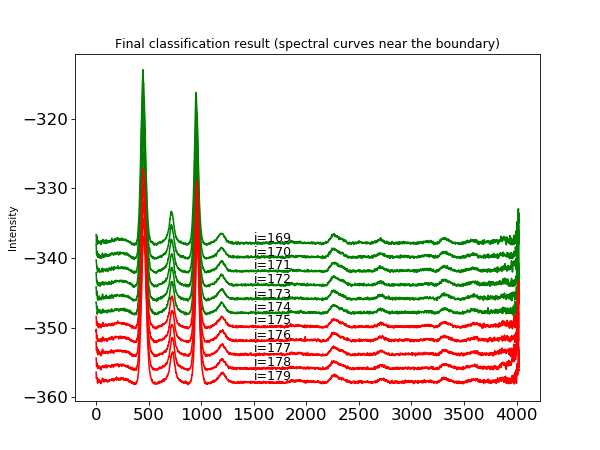

In [57]:

d_index = range(p_start0,p_end0)
Rst_plot_data_cut(X2t.cpu(), d_index, c = FinlPredLabel, title = 'Final classification result (spectral curves near the boundary)')
# Rst_plot_data_cut(intensity_d1[d1_index], d1_index, prob_d1, c = FinlPredLabel_d1[d1_index] , title = 'Classification result d1')

plt.savefig(save_figures_to+"Final classification result_CNN(spectral curves near the boundary).png", bbox_inches='tight', dpi=600)


In [58]:

# ##### =================calculate the label for the whole curve ========================================================
# #======================================================================================================================

# cla    = torch.zeros(C) # for the label 
# # FinlPredLabel = torch.FloatTensor(FinlPredLabel)

# Ct_prid=torch.zeros(N*Ntn, dtype=torch.long).to(device) # predicted test spectra label.
# print('class type:',type(Ct_prid))
# for j in range(Ntn): # test data sets(number of curves)    
#     classId=FinlPredLabel[j]
    
#     for k in range(N):
#         Ct_prid[k+j*N]=classId
# print(Ct_prid.shape,Xt.shape)

In [59]:
# D_len=N
# # different type of labels:
# PCt_prid0 = Ct_prid[p_start0*D_len:p_end0*D_len] # Final predict label with model and weights
# # PZt0      = Zt[p_start0*D_len:p_end0*D_len] # label directly predicted by the model
# # values of x-axis and y-axis
# PXt0      = torch.zeros((p_end0-p_start0)*D_len,2)

# Xt_temp   = Xt[p_start0*D_len:p_end0*D_len,:]
# print(PXt0.shape,Xt.shape)

# n=0
# for j in range(p_start0,p_end0):    
# #     PXt0[(j-p_start0)*D_len:(j+1-p_start0)*D_len,1] = Xt[j*D_len:(j+1)*D_len,1]+6-j/1.
#     PXt0[n*D_len:(n+1)*D_len,1] = Xt_temp[n*D_len:(n+1)*D_len,1]-j/1.
#     PXt0[n*D_len:(n+1)*D_len,0] = Xt_temp[n*D_len:(n+1)*D_len,0]
#     n=n+1
    
# print(PXt0.shape,Xt.shape,PXt0,Xt)

In [60]:
# plt.figure(figsize=(8,6))
# # yue_plot_data(PXt0, PCt_prid0, axl,axr,Pbyl,Pbyh)
# plot_data(PXt0, PCt_prid0)
# plt.title('Final classification result(spectral curves near the boundary)')
# plt.savefig(save_figures_to+"Final classification result(spectral curves near the boundary).png", bbox_inches='tight', dpi=600)


# 5. Feature importance analysis

x_with_grad shape: torch.Size([1, 4023])
dydx: torch.Size([1, 4023])


<IPython.core.display.Javascript object>


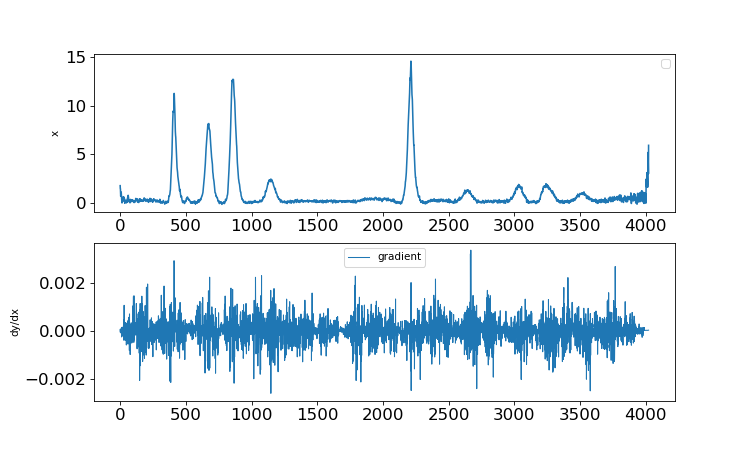

No handles with labels found to put in legend.


In [61]:
# set model to eval mode
model.zero_grad()
model.eval()


x_att_inp = (X2[1:2,:])

criterion = torch.nn.BCELoss()
y_true = y2[1:2,:]
x_with_grad = torch.autograd.Variable(x_att_inp, requires_grad=True)
print('x_with_grad shape:',x_with_grad.shape)
y_pred = model.forward(x_with_grad)

# y_pred = y_pred.squeeze(0)
# print(y_pred.shape, y_true.shape)
loss = criterion(y_pred, y_true)
loss.backward()
# maxypred =  y_pred_o.squeeze(0)
# maxypred.backward()
dydx = x_with_grad.grad
print('dydx:',dydx.shape)


fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(x_with_grad[0].cpu().detach().numpy().T)
axs[0].set_ylabel("x")
axs[0].legend()
axs[1].plot(x_with_grad.grad[0].cpu().numpy().T,linewidth=1,label='gradient')
axs[1].set_ylabel("dy/dx")
# axs[1].plot(np.abs(x_with_grad.grad[0].cpu().numpy()).T,'r',label='absolute gradient')
# axs[1].set_ylabel("dy/dx")
axs[1].legend()

x_with_grad shape: torch.Size([1581, 4023])
torch.Size([1581, 4023])
dydx: torch.Size([1581, 4023])
feature importance: torch.Size([4023])


<IPython.core.display.Javascript object>


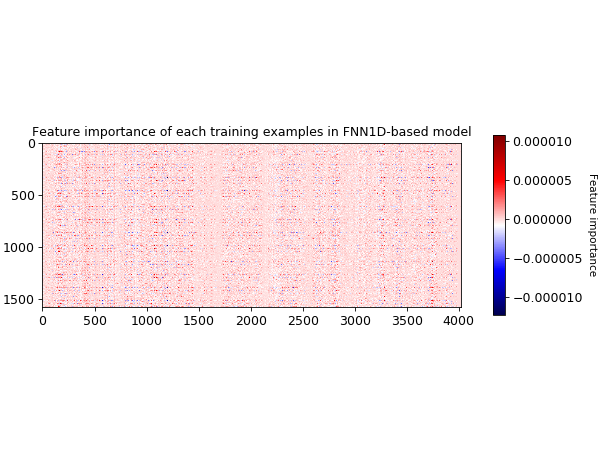

<IPython.core.display.Javascript object>


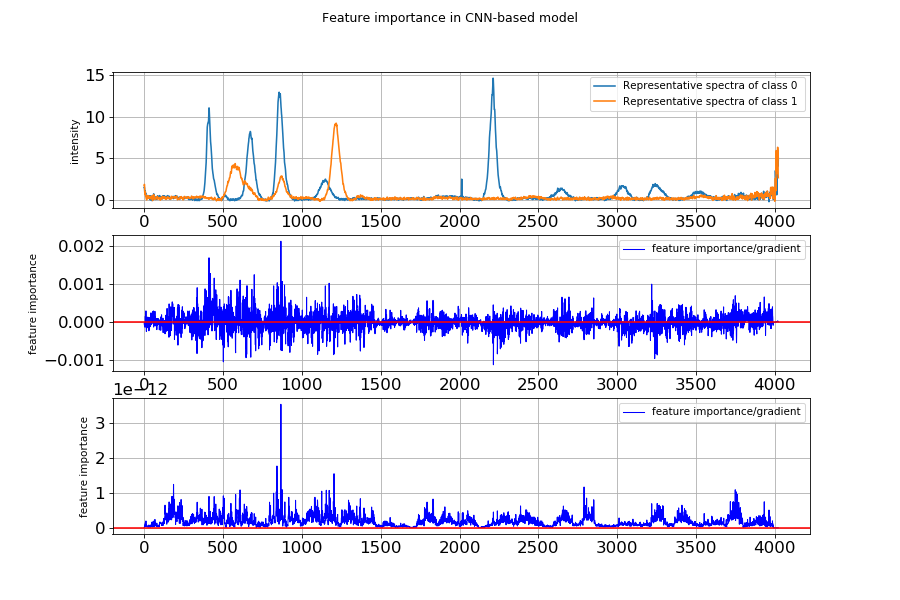

Text(0.5, 0.98, 'Feature importance in CNN-based model')

In [62]:
# set model to eval mode
model.zero_grad()
model.eval()

x_att_inp = (X2)
criterion = torch.nn.BCELoss()
y_true = y2
x_with_grad = torch.autograd.Variable(x_att_inp, requires_grad=True)
print('x_with_grad shape:',x_with_grad.shape)
y_pred = model.forward(x_with_grad)
y_pred = y_pred.squeeze(0)
loss = criterion(y_pred, y_true)
loss.backward()
# maxypred =  y_pred_o.squeeze(0)
# maxypred.backward()
dydx = x_with_grad.grad
print(dydx.shape)
f_impt = torch.sum((torch.squeeze(dydx)),axis=0)
f_impt_s = torch.sum(torch.pow((torch.squeeze(dydx)), 2),axis= 0)/N
print('dydx:',dydx.shape)
print('feature importance:',f_impt.shape)


fix, axs = plt.subplots(1,  constrained_layout=True)  #figsize=(8,6),
cmaps = ["Reds","Blues","gray_r"]
im = axs.imshow(dydx.view(-1,N).cpu().detach().numpy(),   cmap=cm.seismic)#cmaps[0] cmap= plt.cm.coolwarm
axs.set_title('Feature importance of each training examples in FNN1D-based model')
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.4)
cbar.ax.set_ylabel('Feature importance', rotation=-90, va="bottom") #,labelsize=12
axs.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


fig, axs = plt.subplots(3, figsize=(12,8))
axs[0].plot(X2t[0].cpu().detach().numpy().T,label='Representative spectra of class 0 ')
axs[0].plot(X2t[-1].cpu().detach().numpy().T, label='Representative spectra of class 1 ')
axs[0].set_ylabel("intensity")
axs[0].legend()
axs[0].grid()
# axs[1].plot(x_with_grad.grad[0].cpu().numpy().T,'b',linewidth=1,label='gradient')
axs[1].plot(f_impt.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')
axs[1].set_ylabel("feature importance")
axs[1].axhline(y=0, color='r', linestyle='-')
axs[1].legend()
axs[1].grid()
axs[2].plot(f_impt_s.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')
axs[2].set_ylabel("feature importance")
axs[2].axhline(y=0, color='r', linestyle='-')
axs[2].legend()
axs[2].grid()
plt.suptitle('Feature importance in CNN-based model')

# axs[1].plot(np.abs(x_with_grad.grad[0].cpu().numpy()).T,'r',label='absolute gradient')
# axs[1].set_ylabel("dy/dx")

In [63]:
(torch.squeeze(dydx)).shape

torch.Size([1581, 4023])

(4023,)


<IPython.core.display.Javascript object>


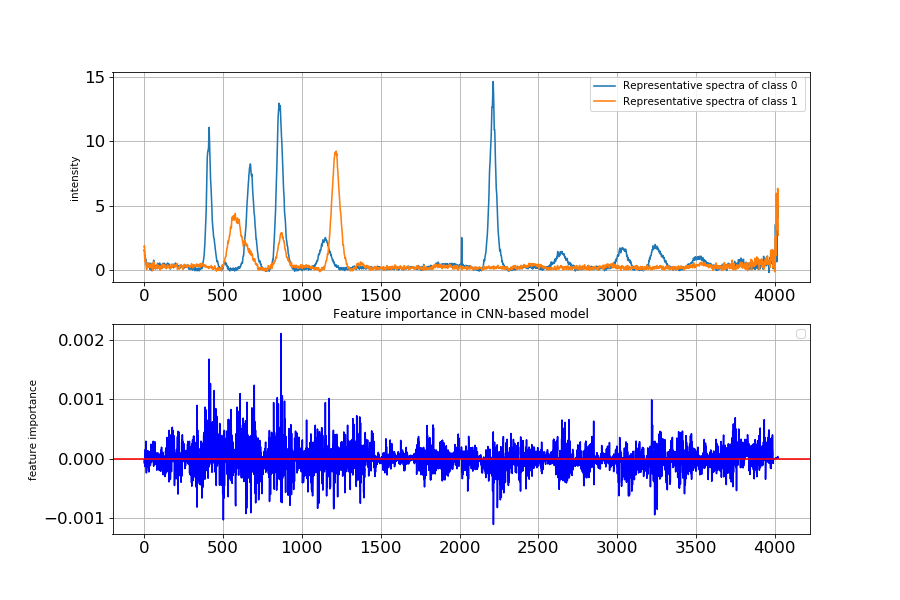

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Feature importance in CNN-based model')

In [64]:
dat = f_impt.cpu().numpy()
print(dat.shape)
np.savetxt('CNN-based(CONV1by1) model feature importance-2mpool3.txt', dat)

fname = 'CNN-based(CONV1by1) model feature importance-2mpool3.txt'
feature_impt = np.loadtxt(fname, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is

fig, axs = plt.subplots(2, figsize=(12,8))
axs[0].plot(X2t[0].cpu().detach().numpy().T,label='Representative spectra of class 0 ')
axs[0].plot(X2t[-1].cpu().detach().numpy().T, label='Representative spectra of class 1 ')
axs[0].set_ylabel("intensity")
axs[0].legend()
axs[0].grid()

# fig, axs = plt.subplots(1, figsize=(10,6))
axs[1].plot(feature_impt,'b')
axs[1].set_ylabel("feature importance")
axs[1].axhline(y=0, color='r', linestyle='-')
axs[1].legend()
axs[1].grid()
plt.title('Feature importance in CNN-based model')

(4023,)


<IPython.core.display.Javascript object>


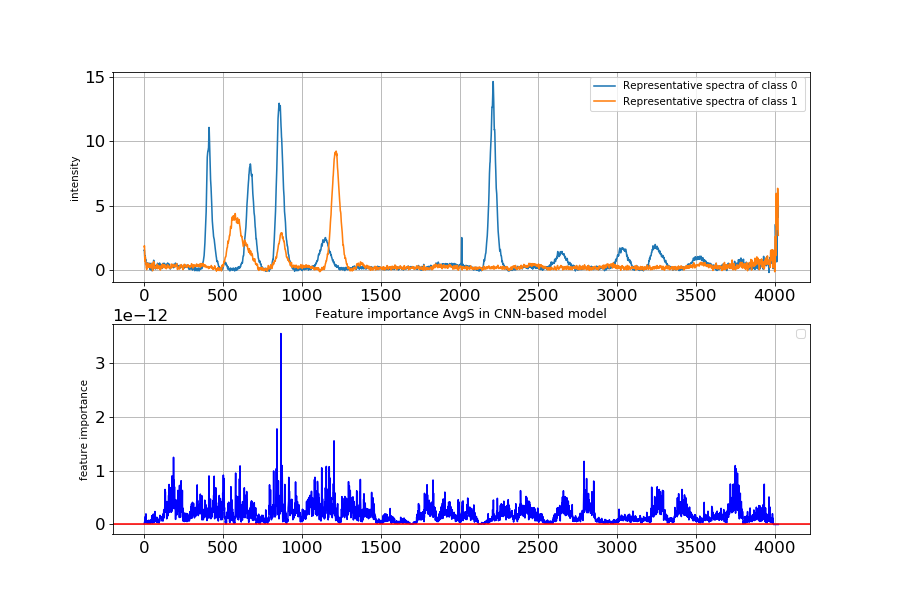

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Feature importance AvgS in CNN-based model')

In [65]:
dat = f_impt_s.cpu().numpy()
print(dat.shape)
np.savetxt('CNN-based(CONV1by1) model feature importance AvgS-2mpool3.txt', dat)

fname = 'CNN-based(CONV1by1) model feature importance AvgS-2mpool3.txt'
feature_impt = np.loadtxt(fname, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is

fig, axs = plt.subplots(2, figsize=(12,8))
axs[0].plot(X2t[0].cpu().detach().numpy().T,label='Representative spectra of class 0 ')
axs[0].plot(X2t[-1].cpu().detach().numpy().T, label='Representative spectra of class 1 ')
axs[0].set_ylabel("intensity")
axs[0].legend()
axs[0].grid()

# fig, axs = plt.subplots(1, figsize=(10,6))
axs[1].plot(feature_impt,'b')
axs[1].set_ylabel("feature importance")
axs[1].axhline(y=0, color='r', linestyle='-')
axs[1].legend()
axs[1].grid()
plt.title('Feature importance AvgS in CNN-based model')

x_with_grad shape: torch.Size([1, 4023])
dydx: torch.Size([1, 4023])


<IPython.core.display.Javascript object>


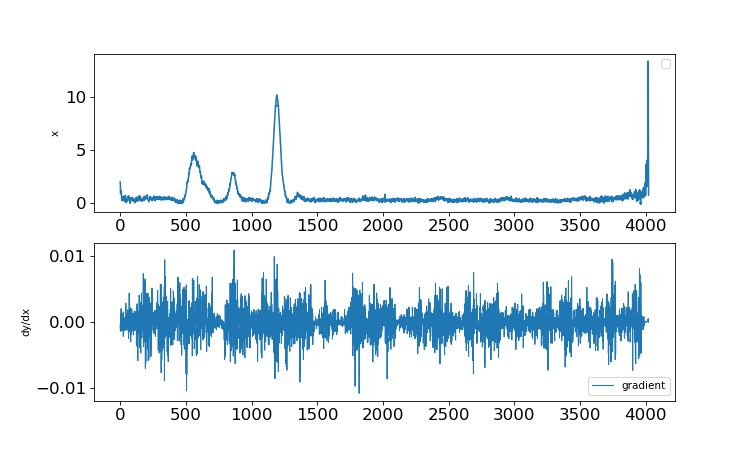

No handles with labels found to put in legend.


In [66]:
x_att_inp = (X2[-2:-1,:])
criterion = torch.nn.BCELoss()
y_true = y2[-2:-1,:]
x_with_grad = torch.autograd.Variable(x_att_inp, requires_grad=True)
print('x_with_grad shape:',x_with_grad.shape)
y_pred = model.forward(x_with_grad)
# y_pred = y_pred.squeeze(0)
loss = criterion(y_pred, y_true)
loss.backward()
# maxypred =  y_pred_o.squeeze(0)
# maxypred.backward()
dydx = x_with_grad.grad
print('dydx:',dydx.shape)


fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(x_with_grad[0].cpu().detach().numpy().T)
axs[0].set_ylabel("x")
axs[0].legend()
axs[1].plot(x_with_grad.grad[0].cpu().numpy().T,linewidth=1,label='gradient')
axs[1].set_ylabel("dy/dx")
# axs[1].plot(np.abs(x_with_grad.grad[0].cpu().numpy()).T,'r',label='absolute gradient')
# axs[1].set_ylabel("dy/dx")
axs[1].legend()

x_with_grad shape: torch.Size([349, 4023])
torch.Size([349, 4023])
dydx: torch.Size([349, 4023])
feature importance: torch.Size([4023])


<IPython.core.display.Javascript object>


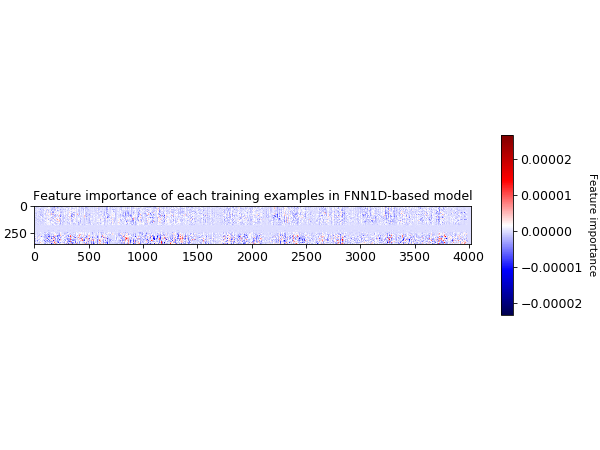

<IPython.core.display.Javascript object>


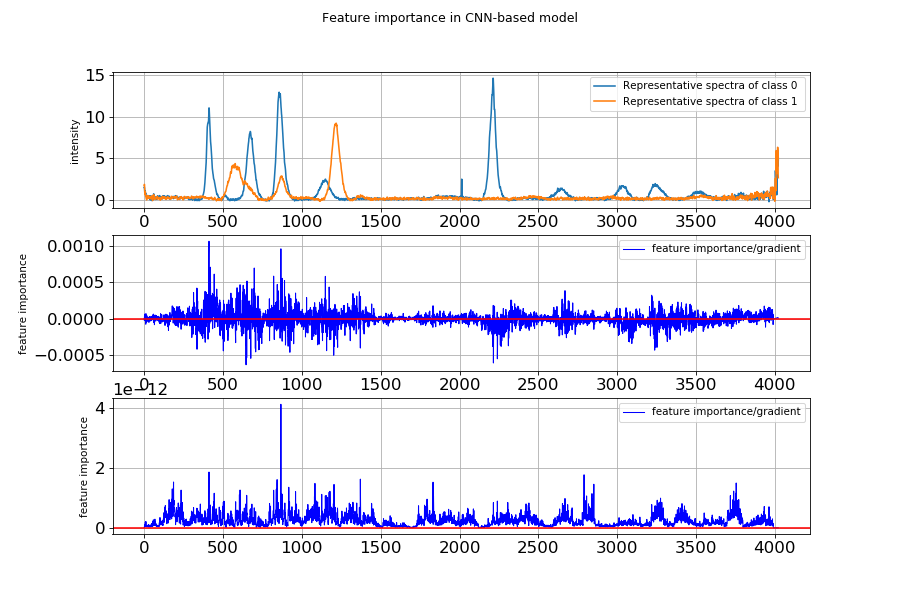

Text(0.5, 0.98, 'Feature importance in CNN-based model')

In [67]:
# set model to eval mode
model.zero_grad()
model.eval()

x_att_inp = (X2t)
criterion = torch.nn.BCELoss()
y_true = y2t
x_with_grad = torch.autograd.Variable(x_att_inp, requires_grad=True)
print('x_with_grad shape:',x_with_grad.shape)
y_pred = model.forward(x_with_grad)
y_pred = y_pred.squeeze(0)
loss = criterion(y_pred, y_true)
loss.backward()
# maxypred =  y_pred_o.squeeze(0)
# maxypred.backward()
dydx = x_with_grad.grad
print(dydx.shape)
f_impt = torch.sum((torch.squeeze(dydx)),axis=0)
f_impt_s = torch.sum(torch.pow((torch.squeeze(dydx)), 2),axis= 0)/N
print('dydx:',dydx.shape)
print('feature importance:',f_impt.shape)


fix, axs = plt.subplots(1,  constrained_layout=True)  #figsize=(8,6),
cmaps = ["Reds","Blues","gray_r"]
im = axs.imshow(dydx.view(-1,N).cpu().detach().numpy(),   cmap=cm.seismic)#cmaps[0] cmap= plt.cm.coolwarm
axs.set_title('Feature importance of each training examples in FNN1D-based model')
cbar = axs.figure.colorbar(im, ax=axs,shrink=0.4)
cbar.ax.set_ylabel('Feature importance', rotation=-90, va="bottom") #,labelsize=12
axs.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


fig, axs = plt.subplots(3, figsize=(12,8))
axs[0].plot(X2t[0].cpu().detach().numpy().T,label='Representative spectra of class 0 ')
axs[0].plot(X2t[-1].cpu().detach().numpy().T, label='Representative spectra of class 1 ')
axs[0].set_ylabel("intensity")
axs[0].legend()
axs[0].grid()
# axs[1].plot(x_with_grad.grad[0].cpu().numpy().T,'b',linewidth=1,label='gradient')
axs[1].plot(f_impt.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')
axs[1].set_ylabel("feature importance")
axs[1].axhline(y=0, color='r', linestyle='-')
axs[1].legend()
axs[1].grid()
axs[2].plot(f_impt_s.cpu().numpy(),'b',linewidth=1,label='feature importance/gradient')
axs[2].set_ylabel("feature importance")
axs[2].axhline(y=0, color='r', linestyle='-')
axs[2].legend()
axs[2].grid()
plt.suptitle('Feature importance in CNN-based model')

# axs[1].plot(np.abs(x_with_grad.grad[0].cpu().numpy()).T,'r',label='absolute gradient')
# axs[1].set_ylabel("dy/dx")

In [68]:
csvdir = model_path
import pandas as pd
BANDS = ['feature']
df = pd.DataFrame(x_with_grad.grad[0].t().cpu().numpy() ,columns=BANDS) #
df.index.name="feature number"
df.to_csv(os.path.join(csvdir,  "dydx.csv"))#"transformer",
print("writing: "+os.path.join(csvdir,  "dydx.csv")) #"transformer",

writing: /gpfs/exfel/data/user/sunyue/Mybinder_test2023/ModelPath/dydx.csv


In [69]:
x_with_grad.grad[0].t().shape

torch.Size([4023])

In [70]:
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

# Other optional model

In [71]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, d_input=4023, d_model=16, nhead=8, nhid=512, nlayers=8, dropout=0.0, o_feature = 1):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(d_input, d_model)
        self.d_model = d_model
#         self.decoder = nn.Linear(d_model, o_feature)
          
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, o_feature),
            nn.Sigmoid()
            )

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
#         nn.init.zeros_(self.decoder.weight)
#         nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=False):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None

        src = self.encoder(src)
#         src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
#         print('After encoder:',output.shape)
        output = self.decoder(output)
#         print('After decoder:',output.shape)
#         return F.log_softmax(output, dim=-1)
        return output